In [ ]:
# !pip install histomicstk --find-links https://girder.github.io/large_image_wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://girder.github.io/large_image_wheels
  Using cached histomicstk-1.2.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (536 kB)
  Using cached large_image-1.16.2-py3-none-any.whl (63 kB)
  Using cached ctk_cli-1.5-py3-none-any.whl (10 kB)
  Using cached nimfa-1.4.0-py2.py3-none-any.whl (4.7 MB)
     |████████████████████████████████| 28.7 MB 1.5 MB/s 
  Using cached girder-slicer-cli-web-1.2.15.zip (178 kB)
  Using cached girder-client-3.1.15.tar.gz (20 kB)
  Using cached diskcache-5.4.0-py3-none-any.whl (44 kB)
  Using cached requests_toolbelt-0.9.1-py2.py3-none-any.whl (54 kB)
  Using cached large_image_source_nd2-1.16.2-py3-none-any.whl (6.8 kB)
  Using cached large_image_source_test-1.16.2-py3-none-any.whl (6.4 kB)
  Using cached large_image_source_gdal-1.16.2-py3-none-any.whl (18 kB)
  Using cached large_image_source_bioformats-1.16.2-py3-none-any.wh

In [6]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

In [ ]:
# sftp://172.16.10.10/home/kmit/Nuclear_Pleomorpism_Birac/Segementation/laxmi_kanth/segmentation_all_datasets/mytoisi-Atyia

In [ ]:
# import os
# os.path.join("/segmentation_all_datasets/mytoisi-Atyi")
# print(os.getcwd())

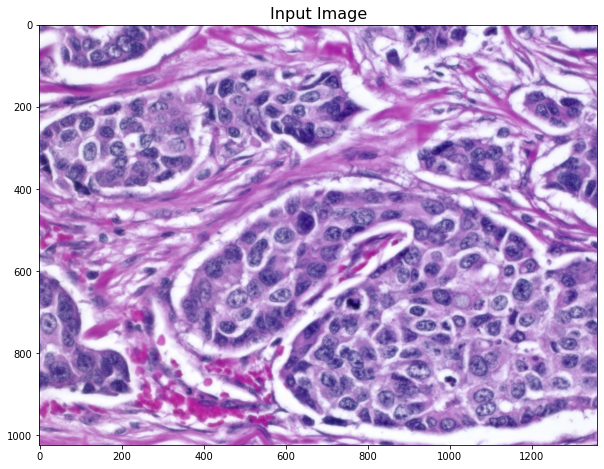

In [9]:
input_image_file = "/content/drive/MyDrive/dataset/BreCaHAD/train/images/Case_1-01.jpg"  # Easy1.png

im_input = skimage.io.imread(input_image_file)[:, :, :3]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)



In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


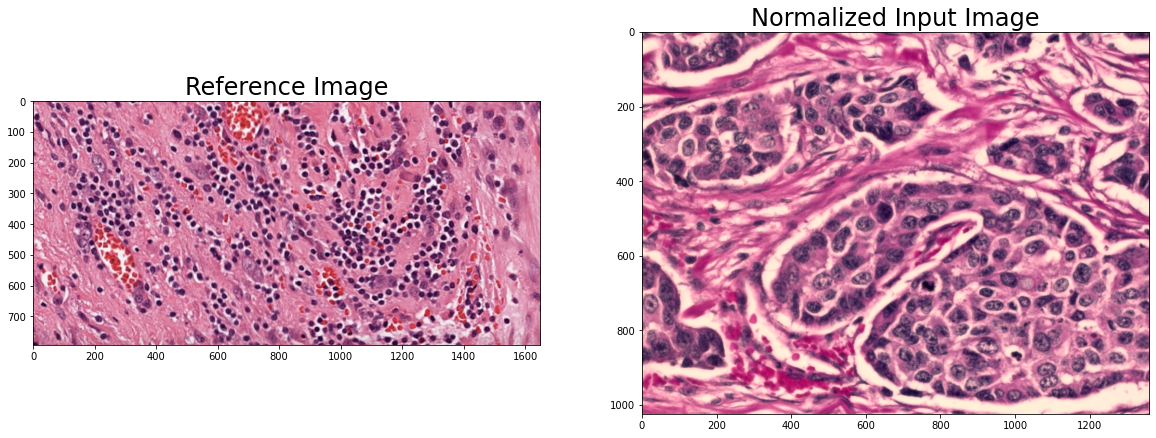

In [11]:
# Load reference image for normalization
ref_image_file = ('https://data.kitware.com/api/v1/file/'
                  '57718cc28d777f1ecd8a883c/download')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)

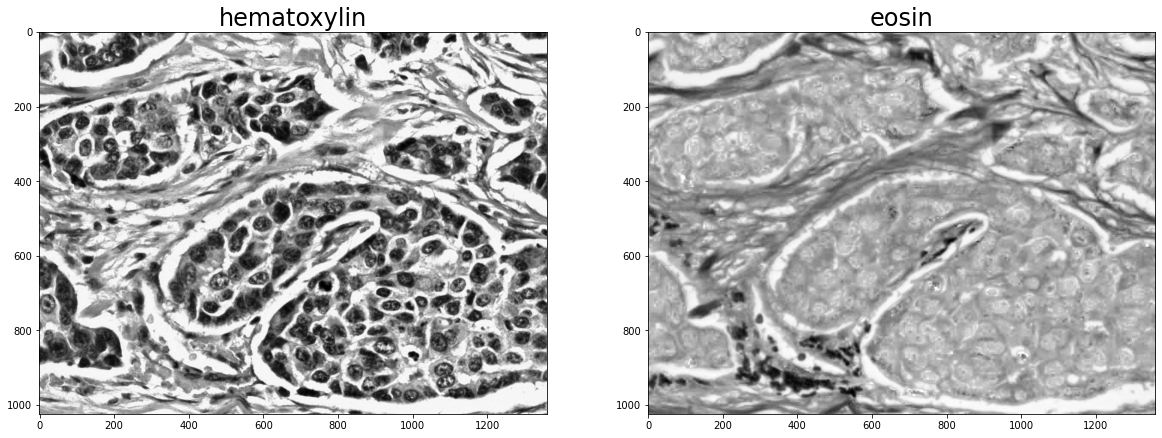

In [12]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

In [14]:
total_boxes=[]

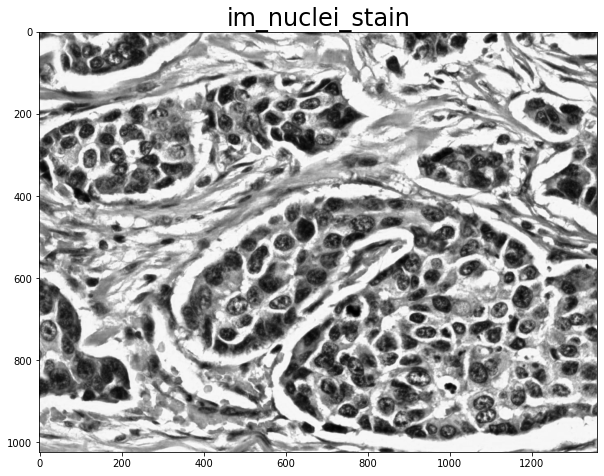

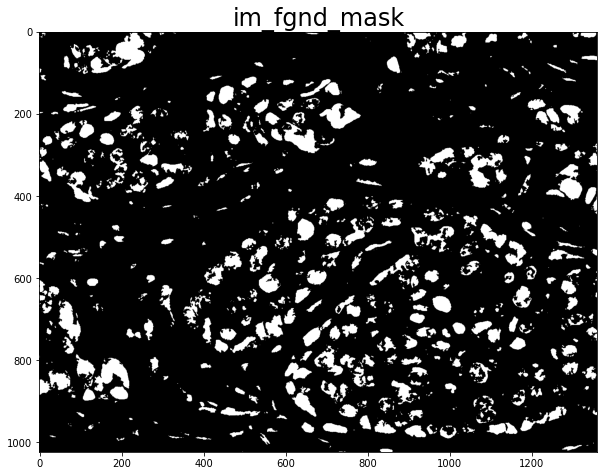

[[   0    0]
 [   0   61]
 [   0  263]
 ...
 [1023  496]
 [1023  731]
 [1023  846]]
Number of nuclei =  465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


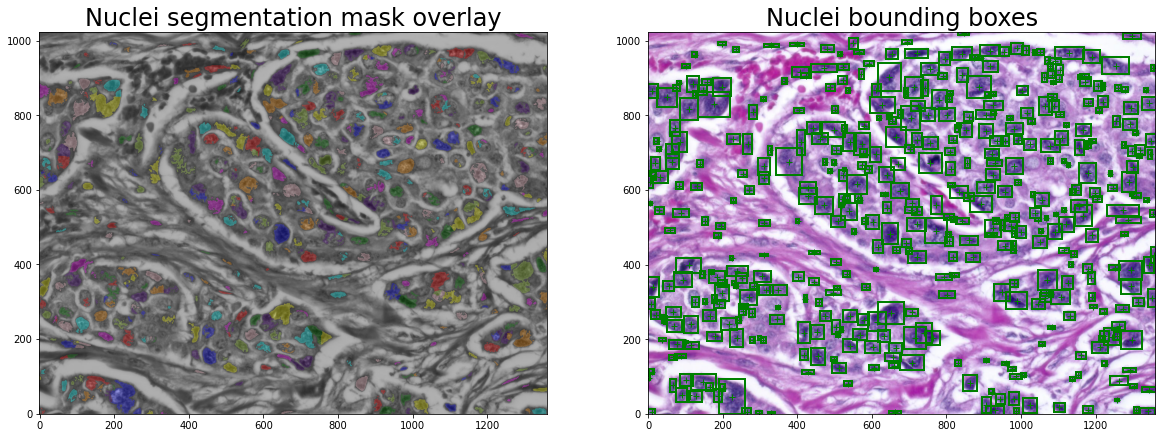

In [15]:
# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]
# im_nuclei stain contains only hematoxylin stained images eosin elimated 
plt.imshow(im_nuclei_stain)
plt.title("im_nuclei_stain",fontsize=titlesize)
plt.show()

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)
# fill binary holes fills the water inside an island
#https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html


plt.imshow(im_fgnd_mask)
plt.title("im_fgnd_mask",fontsize=titlesize)
plt.show()

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 5

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

print(seeds)


# filter out small objects
min_nucleus_area = 40

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print ('Number of nuclei = ', len(objProps))

# print(objProps)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    total_boxes.append(c[:-1][::-1])
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

In [ ]:
skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0)

array([[[0.68431373, 0.38431373, 0.38431373],
        [0.70078431, 0.40078431, 0.40078431],
        [0.7145098 , 0.4145098 , 0.4145098 ],
        ...,
        [0.4145098 , 0.7145098 , 0.7145098 ],
        [0.47215686, 0.47215686, 0.47215686],
        [0.52431373, 0.52431373, 0.52431373]],

       [[0.72      , 0.42      , 0.42      ],
        [0.43372549, 0.43372549, 0.43372549],
        [0.44196078, 0.44196078, 0.44196078],
        ...,
        [0.4254902 , 0.7254902 , 0.7254902 ],
        [0.47764706, 0.47764706, 0.47764706],
        [0.52431373, 0.52431373, 0.52431373]],

       [[0.46117647, 0.46117647, 0.46117647],
        [0.47215686, 0.47215686, 0.47215686],
        [0.47764706, 0.47764706, 0.47764706],
        ...,
        [0.44196078, 0.74196078, 0.74196078],
        [0.48862745, 0.48862745, 0.48862745],
        [0.52431373, 0.52431373, 0.52431373]],

       ...,

       [[0.52156863, 0.52156863, 0.52156863],
        [0.51058824, 0.51058824, 0.51058824],
        [0.49960784, 0

In [16]:
gray_im = np.zeros(im_input.shape[:3], dtype="uint8")
im_color = skimage.color.label2rgb(im_nuclei_seg_mask, gray_im, bg_label=0)

for i in range(gray_im.shape[0]):
    for j in range(gray_im.shape[1]):
        if im_color[i][j][0] + im_color[i][j][1] + im_color[i][j][2] != 0 :
            gray_im[i][j] = 255
 

(1024, 1360, 3)


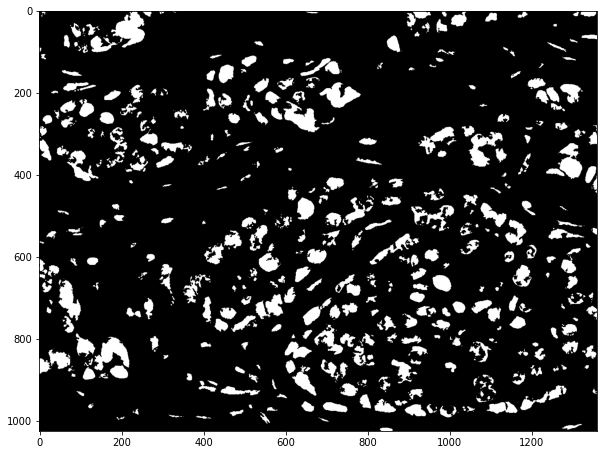

In [17]:
import cv2
plt.imshow(gray_im)
gray_im.shape
cv2.imwrite("new_mask.jpg",gray_im)
print(gray_im.shape)

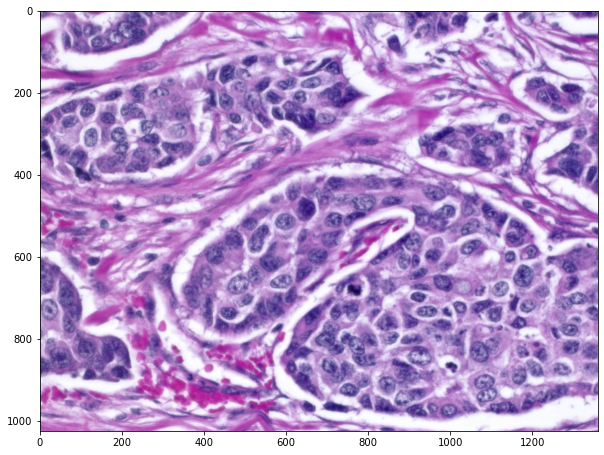

In [ ]:
plt.imshow(im_input)

In [19]:
import os
import json
json_path_dir=os.listdir("/content/drive/MyDrive/dataset/BreCaHAD/groundTruth/")
print(json_path_dir)

# json_path, image_path = glob(lst[0]+'/*.json'), glob(lst[1]+'/*.jpg')
# image_path_dir=os.listdir("/home/kmit/Nuclear_Pleomorpism_Birac/BreCaHAD/images_jpg/")
# print(json_path_dir,image_path_dir)

['Case_7-12.json', 'Case_4-08.json', 'Case_1-04.json', 'Case_17-08.json', 'Case_12-02.json', 'Case_16-04.json', 'Case_15-11.json', 'Case_2-02.json', 'Case_5-08.json', 'Case_14-11.json', 'Case_16-11.json', 'Case_12-03.json', 'Case_2-06.json', 'Case_14-09.json', 'Case_4-07.json', 'Case_12-05.json', 'Case_9-07.json', 'Case_1-08.json', 'Case_16-09.json', 'Case_3-02.json', 'Case_17-10.json', 'Case_15-12.json', 'Case_17-04.json', 'Case_6-02.json', 'Case_10-02.json', 'Case_15-06.json', 'Case_1-01.json', 'Case_11-12.json', 'Case_14-10.json', 'Case_15-04.json', 'Case_15-09.json', 'Case_5-02.json', 'Case_13-03.json', 'Case_2-08.json', 'Case_7-07.json', 'Case_13-07.json', 'Case_4-10.json', 'Case_12-09.json', 'Case_14-02.json', 'Case_17-02.json', 'Case_17-05.json', 'Case_4-02.json', 'Case_4-03.json', 'Case_11-11.json', 'Case_16-02.json', 'Case_17-03.json', 'Case_10-03.json', 'Case_3-04.json', 'Case_1-06.json', 'Case_15-02.json', 'Case_6-07.json', 'Case_15-01.json', 'Case_9-10.json', 'Case_17-12.js

In [20]:
IMG_HEIGHT,IMG_WIDTH=gray_im.shape[0],gray_im.shape[1]

In [21]:
IMG_WIDTH,IMG_HEIGHT

(1360, 1024)

In [24]:
all_points={}
for json_path in json_path_dir:
    js1=json_path[:-5]
    print(js1)
    with open('/content/drive/MyDrive/dataset/BreCaHAD/groundTruth/'+json_path, encoding="utf8", errors='ignore') as f: 
        points=[]
        js=json_path[:-5]
        json_file = json.load(f)
        labels=list(json_file.keys())
        for j in json_file[labels[3]]:
            cord = j['x'],j['y']
            points.append(cord)
        all_points[js1]=points
print(all_points)

Case_7-12
Case_4-08
Case_1-04
Case_17-08
Case_12-02
Case_16-04
Case_15-11
Case_2-02
Case_5-08
Case_14-11
Case_16-11
Case_12-03
Case_2-06
Case_14-09
Case_4-07
Case_12-05
Case_9-07
Case_1-08
Case_16-09
Case_3-02
Case_17-10
Case_15-12
Case_17-04
Case_6-02
Case_10-02
Case_15-06
Case_1-01
Case_11-12
Case_14-10
Case_15-04
Case_15-09
Case_5-02
Case_13-03
Case_2-08
Case_7-07
Case_13-07
Case_4-10
Case_12-09
Case_14-02
Case_17-02
Case_17-05
Case_4-02
Case_4-03
Case_11-11
Case_16-02
Case_17-03
Case_10-03
Case_3-04
Case_1-06
Case_15-02
Case_6-07
Case_15-01
Case_9-10
Case_17-12
Case_15-08
Case_8-03
Case_15-07
Case_13-11
Case_3-07
Case_6-05
Case_14-07
Case_12-11
Case_9-08
Case_14-01
Case_9-03
Case_10-07
Case_6-01
Case_7-10
Case_10-05
Case_2-05
Case_3-05
Case_3-08
Case_14-06
Case_12-10
Case_15-03
Case_10-08
Case_13-05
Case_11-09
Case_11-13
Case_3-03
Case_12-07
Case_14-05
Case_6-03
Case_4-05
Case_7-09
Case_16-07
Case_4-06
Case_2-04
Case_2-03
Case_7-08
Case_4-01
Case_4-09
Case_10-10
Case_4-04
Case_12-0

In [25]:
print(all_points.keys())

dict_keys(['Case_7-12', 'Case_4-08', 'Case_1-04', 'Case_17-08', 'Case_12-02', 'Case_16-04', 'Case_15-11', 'Case_2-02', 'Case_5-08', 'Case_14-11', 'Case_16-11', 'Case_12-03', 'Case_2-06', 'Case_14-09', 'Case_4-07', 'Case_12-05', 'Case_9-07', 'Case_1-08', 'Case_16-09', 'Case_3-02', 'Case_17-10', 'Case_15-12', 'Case_17-04', 'Case_6-02', 'Case_10-02', 'Case_15-06', 'Case_1-01', 'Case_11-12', 'Case_14-10', 'Case_15-04', 'Case_15-09', 'Case_5-02', 'Case_13-03', 'Case_2-08', 'Case_7-07', 'Case_13-07', 'Case_4-10', 'Case_12-09', 'Case_14-02', 'Case_17-02', 'Case_17-05', 'Case_4-02', 'Case_4-03', 'Case_11-11', 'Case_16-02', 'Case_17-03', 'Case_10-03', 'Case_3-04', 'Case_1-06', 'Case_15-02', 'Case_6-07', 'Case_15-01', 'Case_9-10', 'Case_17-12', 'Case_15-08', 'Case_8-03', 'Case_15-07', 'Case_13-11', 'Case_3-07', 'Case_6-05', 'Case_14-07', 'Case_12-11', 'Case_9-08', 'Case_14-01', 'Case_9-03', 'Case_10-07', 'Case_6-01', 'Case_7-10', 'Case_10-05', 'Case_2-05', 'Case_3-05', 'Case_3-08', 'Case_14-06',

In [26]:
all_points['Case_1-01']

[(0.08808104886769964, 0.30274135876042907),
 (0.053978826333870855, 0.2598331346841478),
 (0.08718362195891467, 0.2359952324195471),
 (0.05218397251630092, 0.22526817640047675),
 (0.05667110706022576, 0.3456495828367104),
 (0.14192666339479773, 0.29916567342073896),
 (0.14461894412115264, 0.3230035756853397),
 (0.12397812521909837, 0.2526817640047676),
 (0.08808104886769964, 0.041716328963051254),
 (0.0638505223305055, 0.03933253873659118),
 (0.04769683797237608, 0.0631704410011919),
 (0.10064502559068919, 0.07270560190703218),
 (0.12936268667180817, 0.06793802145411204),
 (0.1544906401177873, 0.04052443384982122),
 (0.17333660520227162, 0.1835518474374255),
 (0.15718292084414218, 0.22288438617401668),
 (0.18859286265161607, 0.27771156138259834),
 (0.21910537755030499, 0.19308700834326578),
 (0.24872046554020893, 0.28843861740166865),
 (0.23974619645235926, 0.3206197854588796),
 (0.19846455864825072, 0.300357568533969),
 (0.17692631283741148, 0.33849821215733017),
 (0.2271822197293697

In [40]:

original_points=[]
for point in all_points['Case_1-01']:
    x=int(point[1]*gray_im.shape[0])
    y=int(point[0]*gray_im.shape[1])
    # print(gray_im[x][y])
    original_points.append([x,y])
print(sorted(original_points))

[[25, 1015], [40, 86], [40, 988], [41, 210], [42, 119], [45, 953], [47, 930], [64, 64], [69, 175], [74, 136], [79, 863], [123, 514], [135, 714], [151, 454], [152, 490], [167, 1208], [175, 611], [178, 666], [179, 535], [183, 489], [186, 1291], [187, 235], [197, 297], [198, 721], [205, 516], [206, 561], [208, 1220], [209, 1256], [213, 638], [222, 452], [228, 213], [230, 70], [233, 611], [240, 1270], [241, 118], [247, 577], [252, 344], [256, 692], [258, 168], [262, 643], [266, 73], [284, 256], [292, 991], [295, 338], [306, 193], [307, 269], [310, 119], [312, 1114], [314, 1070], [327, 1024], [328, 326], [330, 196], [344, 975], [346, 240], [353, 77], [361, 308], [378, 1298], [397, 1341], [411, 872], [417, 711], [439, 615], [444, 960], [454, 687], [455, 853], [461, 788], [478, 643], [484, 993], [484, 1052], [501, 717], [506, 511], [511, 594], [518, 1047], [546, 1152], [549, 712], [555, 528], [560, 913], [563, 478], [568, 1053], [582, 1190], [591, 675], [598, 433], [598, 954], [609, 894], [60

In [29]:
from skimage.draw import disk
from skimage.draw import circle_perimeter,circle_perimeter_aa
# circle_perimeter??
from skimage.draw import  set_color
from skimage.draw import rectangle

In [30]:
# Importing the pillow library's
# desired modules
from PIL import Image, ImageDraw

# Opening the image (R prefixed to
# string in order to deal with '\'
# in paths)
img = Image.open("/content/drive/MyDrive/dataset/BreCaHAD/train/images/Case_1-01.jpg")
print(img)
# print(img)
img.show()

# Converting the image to RGB mode
# img1 = img.convert("RGB")

# Coordinates of the pixel whose value
# would be used as seed
# print(IMG_WIDTH)
temp_im=gray_im.copy()
print(len(all_points['Case_1-01']))
# c=0
mask_color = (100, 100, 255)
detections=[]
original_points=[]
arr1=[]
arr2=[]
for point in all_points['Case_1-01']:
    x=int(point[1]*gray_im.shape[0])
    y=int(point[0]*gray_im.shape[1])
    print(gray_im[x][y])
    original_points.append([x,y])
    if(sum(gray_im[x][y])>200):
        detections.append([x,y])
    else:
        var=True
        for xx in range(-2,3):
            for yy in range(-2,3):
                if(sum(gray_im[x+xx][y+yy])>200):
                    detections.append([x+xx,y+yy])
                    var=False
                    break
                if(var==False):
                    break
                    
#         detections.append([x,y])
#     print(round(x),round(y))
    best=1000000
    rr1,cc1=circle_perimeter(x,y,10,shape=temp_im.shape)
    rr1, cc1 = rectangle((x-12, y+12),(x+12, y-12), shape=temp_im.shape)
    temp_im[rr1,cc1,:] = (255, 0, 0)
#     image1[rr1,cc1,:] = mask_color
#     cv2.rectangle(temp_im, (y+15,x-15), (y-15,x+15), (255, 0, 0),2 )
    
#     print(round(x_new),round(y_new),round(seeds[best_ind][0]),round(seeds[best_ind][1]),np.sqrt(diff))
#     arr1.append(x_new)
#     arr2.append(y_new)
# arr1.sort()
# arr2.sort()
# print(arr1)
# print('\n\n\n')
# print(arr2)
#     rr1=round(total_boxes[best_ind][0])
#     cc1=round(total_boxes[best_ind][1])
#     rr1,cc1=circle_perimeter(round(total_boxes[best_ind][0]),round(total_boxes[best_ind][1]),10,shape=gray_im.shape)
#             #rr1, cc1 = disk((x,y),10,shape=image1.shape)
#     rr1, cc1 = rectangle((x-12, y+12),(x+12, y-12), shape=gray_im.shape)
#     print(rr1,cc1)
#     gray_im[rr1,cc1,:] = mask_color
#     cv2.rectangle(gray_im, (y+15,x-15), (y-15,x+15), (255, 255, 255),2 )
# plt.imshow(gray_im)
#         cv2.imwrite(mask_path+i+'_mask.png', image1)
#     print(gray_im[round(x_new)][round(y_new)])
#     print(gray_im[round(x_new)][round(y_new)])
#     if(gray_im[round(x_new)][round(y_new)][0]==0):
#         print(round(x_new),round(y_new))
#         c+=1
# print(c)

# # Pixel Value which would be used for
# # replacement
#     rep_value = (255, 255, 0)

# # Calling the floodfill() function and
# # passing it image, seed, value and
# # thresh as arguments
#     ImageDraw.floodfill(img, seed, rep_value, thresh=5)

# # Displaying the image
# img.show()


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1360x1024 at 0x7F4EBD350890>
140
[0 0 0]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[0 0 0]
[0 0 0]
[255 255 255]
[0 0 0]
[255 255 255]
[255 255 255]
[255 255 255]
[0 0 0]
[255 255 255]
[255 255 255]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[255 255 255]
[255 255 255]
[0 0 0]
[255 255 255]
[255 255 255]
[255 255 255]
[0 0 0]
[0 0 0]
[255 255 255]
[0 0 0]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[0 0 0]
[0 0 0]
[0 0 0]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[0 0 0]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[0 0 0]
[0 0 0]
[255 255 255]
[255 255 255]
[0 0 0]
[255 255 255]
[0 0 0]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[0 0 0]
[255 255 255]
[255 255 255]
[255 255 255]
[0 0 0]
[255 255 255]
[0 0 0]
[255 255 255]
[255 255 255]
[255 2

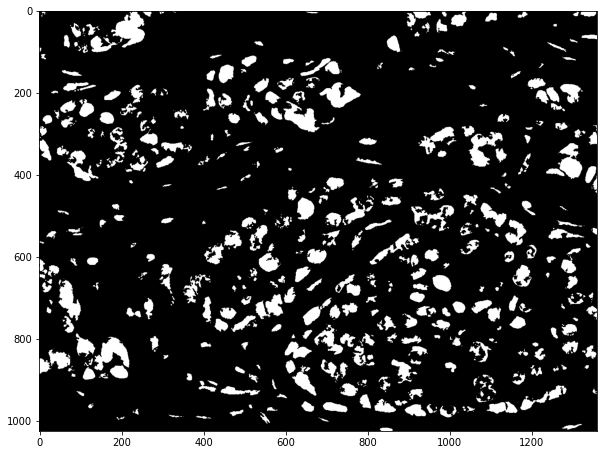

In [31]:
plt.imshow(gray_im)

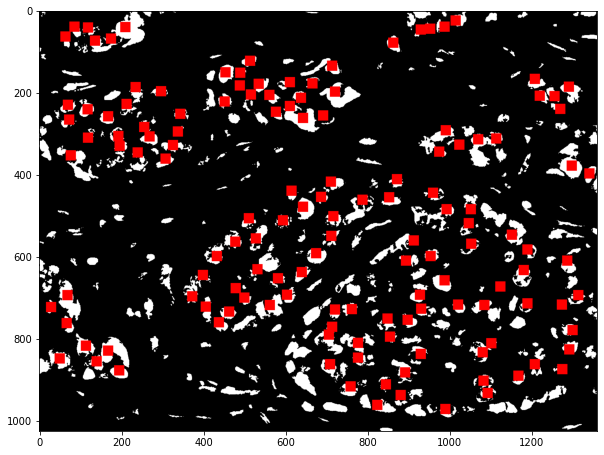

In [32]:
plt.imshow(temp_im)

In [33]:
print(len(detections))

134


In [ ]:
cv2.imwrite("maks_red.jpg",temp_im)

True

In [35]:
print(sorted(detections))

[[25, 1015], [40, 86], [40, 988], [41, 210], [43, 951], [64, 64], [74, 136], [79, 863], [123, 514], [135, 714], [151, 454], [167, 1208], [175, 611], [178, 666], [179, 535], [186, 1291], [187, 235], [198, 299], [198, 721], [206, 561], [208, 1220], [209, 1256], [211, 636], [212, 636], [213, 636], [214, 636], [222, 452], [230, 70], [231, 609], [240, 1270], [241, 118], [247, 577], [252, 344], [258, 168], [262, 643], [266, 73], [282, 256], [292, 991], [307, 269], [312, 1114], [314, 1070], [328, 194], [328, 326], [329, 194], [330, 194], [331, 194], [332, 194], [344, 238], [344, 977], [345, 238], [346, 238], [346, 973], [353, 77], [361, 308], [378, 1298], [397, 1341], [411, 872], [417, 711], [439, 615], [444, 960], [454, 687], [457, 851], [478, 643], [484, 993], [486, 1054], [501, 717], [506, 511], [509, 595], [518, 1047], [546, 1152], [549, 712], [553, 527], [555, 526], [556, 526], [557, 526], [560, 913], [563, 478], [568, 1053], [584, 1191], [591, 675], [598, 433], [598, 954], [607, 892], [

In [60]:
file_0_1=[]
for point in detections:
  x,y=point[0],point[1]
  if(y<=255 and x>255 and x<=511):
    x-=255
    file_0_1.append((x,y))
print(file_0_1)

[(11, 73), (98, 77), (73, 194), (74, 194), (75, 194), (76, 194), (77, 194), (3, 168), (89, 238), (90, 238), (91, 238)]


In [50]:
from collections import deque
def floodfill(img,point,col_now,col_to):
    arr1=[1,-1,0,0,1,1,-1,-1]
    arr2=[0,0,1,-1,1,-1,1,-1]
    x_max,y_max=img.shape[0],img.shape[1]
    q=deque()
    q.append(point)
    st=set()
    st.add(point)
    while(len(q)>0):
      point=q.popleft()
      x,y=point[0],point[1]
      mask_final[x][y]=[255,255,255]
      img[x][y]=col_to
      for a in range(8):
        dx=x+arr1[a]
        dy=y+arr2[a]
        if(dx>=0 and dx<x_max and dy>=0 and dy<y_max and (abs(col_now[0]-img[dx][dy][0])+abs(col_now[2]-img[dx][dy][2])+abs(col_now[1]-img[dx][dy][1])<30) and (dx,dy) not in st):
            q.append((dx,dy))
            st.add((dx,dy))

In [53]:
img_for_flood_fill=gray_im.copy()
col_now=[255,255,255]
col_to=[0,255,0]

mask_final=np.zeros(im_input.shape[:3], dtype="uint8")

for point in detections:
    # print("here")
    floodfill(img_for_flood_fill,tuple(point),col_now,col_to)

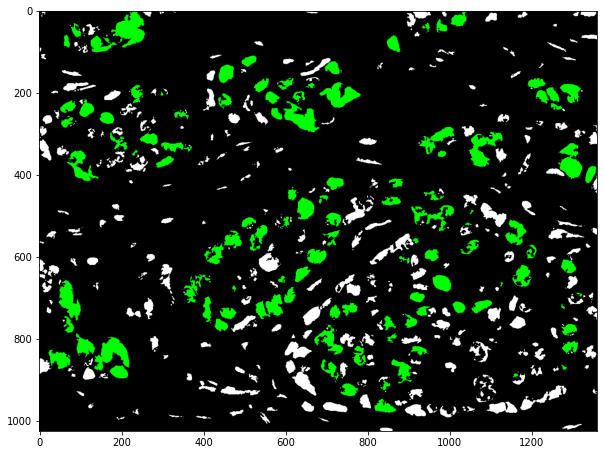

In [54]:
plt.imshow(img_for_flood_fill)

In [ ]:
cv2.imwrite('mask_green.jpg',img_for_flood_fill)

True

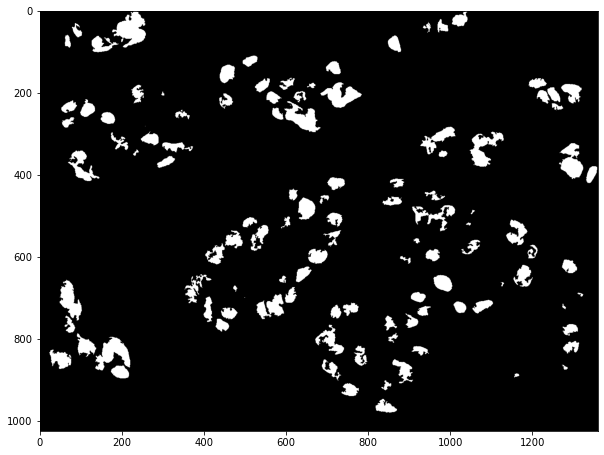

In [ ]:
plt.imshow(mask_final)

In [ ]:
cv2.imwrite("mask_final.jpg",mask_final)

True

In [55]:
for point in detections:
    x,y=point[0],point[1]
    print(gray_im[x][y])

[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 255 255]
[255 2

In [ ]:
print(original_points)

[[310, 119], [266, 73], [241, 118], [230, 70], [353, 77], [306, 193], [330, 196], [258, 168], [42, 119], [40, 86], [64, 64], [74, 136], [69, 175], [41, 210], [187, 235], [228, 213], [284, 256], [197, 297], [295, 338], [328, 326], [307, 269], [346, 240], [361, 308], [222, 452], [151, 454], [152, 490], [183, 489], [123, 514], [205, 516], [179, 535], [206, 561], [175, 611], [178, 666], [213, 638], [256, 692], [233, 611], [247, 577], [262, 643], [135, 714], [198, 721], [79, 863], [693, 69], [722, 29], [761, 67], [847, 50], [816, 114], [828, 168], [854, 140], [876, 195], [696, 373], [644, 399], [721, 406], [733, 463], [759, 438], [676, 479], [630, 532], [699, 500], [598, 433], [563, 478], [555, 528], [506, 511], [511, 594], [439, 615], [478, 643], [417, 711], [454, 687], [461, 788], [501, 717], [549, 712], [591, 675], [652, 582], [637, 640], [455, 853], [411, 872], [444, 960], [484, 993], [560, 913], [609, 894], [727, 762], [728, 721], [770, 714], [789, 706], [861, 709], [809, 777], [845, 7

In [ ]:
gray_im[310][119]

array([0, 0, 0], dtype=uint8)

In [ ]:
print(nearest_seed)

NameError: name 'nearest_seed' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill

In [ ]:
flood(gray_im, (240, 265), tolerance=0.03)

ValueError: operands could not be broadcast together with shapes (2,) (3,) 